## Sensitivity Analysis for Global Seed

This jupyter notebook creates plots to study the impact of varying the global seed for base-case analysis

### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (116, )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
# Plotly for plotting 
#!pip install plotly

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from math import trunc

### 2. Environment Variables

In [6]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [8]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [9]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [10]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [11]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [12]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

count  analysis_id
0     875          576
1     904          587
2     853          578
3     911          595
4     916          589
5     884          567
6     916          575
7     855          566
8     924          592
9     894          588
10    895          586
11    931          572
12    840          593
13    917          577
14    882          581
15    859          591
16    921          573
17    921          585
18    852          582
19    890          583
20    891          569
21    861          590
22    919          579
23    915          584
24    881          574
25    857          571
26    933          594
27    876          568
28    873          570
29    938          580

In [13]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

count  analysis_id
0     868          576
1     900          587
2     848          578
3     910          595
4     910          589
5     879          567
6     902          575
7     850          566
8     914          592
9     888          588
10    890          586
11    929          572
12    835          593
13    912          577
14    877          581
15    857          591
16    917          573
17    918          585
18    850          582
19    879          583
20    888          569
21    858          590
22    913          579
23    911          584
24    876          574
25    855          571
26    928          594
27    869          568
28    868          570
29    932          580

In [14]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

count  analysis_id
0       5          566
1       5          567
2       7          568
3       3          569
4       5          570
5       2          571
6       2          572
7       4          573
8       5          574
9      14          575
10      7          576
11      5          577
12      5          578
13      6          579
14      6          580
15      5          581
16      2          582
17     11          583
18      4          584
19      3          585
20      5          586
21      4          587
22      6          588
23      6          589
24      3          590
25      2          591
26     10          592
27      5          593
28      5          594
29      1          595

In [15]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, ap.param_value as global_seed
from ev_stranded est
         join (
    select param_value, analysis_id
    from analysis_params
    where param_id = 1) as ap
              on est.analysis_id = ap.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY global_seed;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

stranded_lat  stranded_lng  analysis_id global_seed
0     48.104953   -123.388017          587         252
1     46.983513   -121.535465          587         252
2     48.451401   -122.408001          587         252
3     48.805947   -122.197628          587         252
4     48.097817   -123.323943          590         257

In [16]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

sum  analysis_id
0   100927.0          576
1   105956.0          587
2   102106.0          578
3   105405.0          595
4   108504.0          589
5   103951.0          567
6   109003.0          575
7    99958.0          566
8   107557.0          592
9   102330.0          588
10  103536.0          586
11  105590.0          572
12   99970.0          593
13  103369.0          577
14  102186.0          581
15  100704.0          591
16  107263.0          573
17  106932.0          585
18  100913.0          582
19  103453.0          583
20  103192.0          569
21   99724.0          590
22  107400.0          579
23  103542.0          584
24  102160.0          574
25   98025.0          571
26  108979.0          594
27   99817.0          568
28  101945.0          570
29  111160.0          580

In [17]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

count  analysis_id
0     571          576
1     603          587
2     579          578
3     545          595
4     616          589
5     574          567
6     634          575
7     559          566
8     629          592
9     558          588
10    595          586
11    595          572
12    561          593
13    591          577
14    609          581
15    575          591
16    613          573
17    589          585
18    563          582
19    605          583
20    613          569
21    547          590
22    608          579
23    630          584
24    593          574
25    542          571
26    598          594
27    566          568
28    562          570
29    632          580

In [18]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

count  analysis_id
0      86          576
1      94          577
2     100          587
3      98          578
4     110          581
5     106          595
6     105          591
7     117          573
8     115          585
9     107          582
10    111          589
11    143          583
12    125          569
13    120          567
14    122          575
15     82          590
16    104          566
17    111          592
18    105          579
19    121          584
20     87          574
21    114          571
22     95          594
23    111          568
24     98          588
25    103          586
26     88          572
27    120          593
28    112          570
29    129          580

In [19]:
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       ap.param_value               as global_seed
FROM evse_power_draw epd
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on epd.analysis_id = ap.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, ap.param_value
ORDER BY global_seed, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

analysis_id            datetime  total_power global_seed
0              587 2019-07-01 06:00:47            0         252
1              587 2019-07-01 06:01:47            0         252
2              587 2019-07-01 06:02:47            0         252
3              587 2019-07-01 06:03:47            0         252
4              587 2019-07-01 06:04:47            0         252
...            ...                 ...          ...         ...
36451          582 2019-07-02 06:13:54            0         985
36452          582 2019-07-02 06:14:54            0         985
36453          582 2019-07-02 06:15:54            0         985
36454          582 2019-07-02 06:16:54            0         985
36455          582 2019-07-02 06:17:54            0         985

[36456 rows x 4 columns]

In [20]:
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       ap.param_value,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on ets.analysis_id = ap.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
group by ets.analysis_id, ap.param_value, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
count_stats

sim_count  analysis_id param_value  fin_count      evmt  str_count  \
0         855          566         565        850   99958.0          5   
1         884          567         771        879  103951.0          5   
2         876          568         767        869   99817.0          7   
3         891          569         630        888  103192.0          3   
4         873          570          54        868  101945.0          5   
5         857          571         557        855   98025.0          2   
6         931          572         734        929  105590.0          2   
7         921          573         510        917  107263.0          4   
8         881          574         615        876  102160.0          5   
9         916          575         496        902  109003.0         14   
10        875          576         664        868  100927.0          7   
11        917          577         605        912  103369.0          5   
12        853          578         830        848  102106.0          5   
13        919          579         652        913  107400.0          6   
14        938          580         404        932  111160.0          6   
15        882          581         798        877  102186.0          5   
16        852          582         985        850  100913.0          2   
17        890          583         742        879  103453.0         11   
18        915          584         352        911  103542.0          4   
19        921          585          85        918  106932.0          3   
20        895          586         735        890  103536.0          5   
21        904          587         252        900  105956.0          4   
22        894          588         886        888  102330.0          6   
23        916          589         634        910  108504.0          6   
24        861          590         257        858   99724.0          3   
25        859          591         289        857  100704.0          2   
26        924          592         854        914  107557.0         10   
27        840          593         885        835   99970.0          5   
28        933          594         982        928  108979.0          5   
29        911          595         669        910  105405.0          1   

    cs_count  wait_count  
0        559         104  
1        574         120  
2        566         111  
3        613         125  
4        562         112  
5        542         114  
6        595          88  
7        613         117  
8        593          87  
9        634         122  
10       571          86  
11       591          94  
12       579          98  
13       608         105  
14       632         129  
15       609         110  
16       563         107  
17       605         143  
18       630         121  
19       589         115  
20       595         103  
21       603         100  
22       558          98  
23       616         111  
24       547          82  
25       575         105  
26       629         111  
27       561         120  
28       598          95  
29       545         106

In [21]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['param_value'])
count_stats

sim_count  analysis_id param_value  fin_count      evmt  str_count  \
21        904          587         252        900  105956.0          4   
24        861          590         257        858   99724.0          3   
25        859          591         289        857  100704.0          2   
18        915          584         352        911  103542.0          4   
14        938          580         404        932  111160.0          6   
9         916          575         496        902  109003.0         14   
7         921          573         510        917  107263.0          4   
4         873          570          54        868  101945.0          5   
5         857          571         557        855   98025.0          2   
0         855          566         565        850   99958.0          5   
11        917          577         605        912  103369.0          5   
8         881          574         615        876  102160.0          5   
3         891          569         630        888  103192.0          3   
23        916          589         634        910  108504.0          6   
13        919          579         652        913  107400.0          6   
10        875          576         664        868  100927.0          7   
29        911          595         669        910  105405.0          1   
6         931          572         734        929  105590.0          2   
20        895          586         735        890  103536.0          5   
17        890          583         742        879  103453.0         11   
2         876          568         767        869   99817.0          7   
1         884          567         771        879  103951.0          5   
15        882          581         798        877  102186.0          5   
12        853          578         830        848  102106.0          5   
19        921          585          85        918  106932.0          3   
26        924          592         854        914  107557.0         10   
27        840          593         885        835   99970.0          5   
22        894          588         886        888  102330.0          6   
28        933          594         982        928  108979.0          5   
16        852          582         985        850  100913.0          2   

    cs_count  wait_count  
21       603         100  
24       547          82  
25       575         105  
18       630         121  
14       632         129  
9        634         122  
7        613         117  
4        562         112  
5        542         114  
0        559         104  
11       591          94  
8        593          87  
3        613         125  
23       616         111  
13       608         105  
10       571          86  
29       545         106  
6        595          88  
20       595         103  
17       605         143  
2        566         111  
1        574         120  
15       609         110  
12       579          98  
19       589         115  
26       629         111  
27       561         120  
22       558          98  
28       598          95  
16       563         107

In [47]:
max_counts = count_stats[['sim_count','fin_count', 'str_count', 'evmt', 'cs_count', 'wait_count']].max()
max_counts

sim_count        938.0
fin_count        932.0
str_count         14.0
evmt          111160.0
cs_count         634.0
wait_count       143.0
dtype: float64

In [50]:
max_counts_idxs = count_stats[['sim_count','fin_count', 'str_count', 'evmt', 'cs_count', 'wait_count']].idxmax()

In [52]:
max_counts_idxs['sim_count']

14

In [57]:
count_stats['param_value'][max_counts_idxs['sim_count']]

'404'

In [69]:
min_counts = count_stats[['sim_count','fin_count', 'str_count', 'evmt', 'cs_count', 'wait_count']].min()
min_counts

sim_count       840.0
fin_count       835.0
str_count         1.0
evmt          98025.0
cs_count        542.0
wait_count       82.0
dtype: float64

In [71]:
min_counts_idxs = count_stats[['sim_count','fin_count', 'str_count', 'evmt', 'cs_count', 'wait_count']].idxmin()
min_counts_idxs

sim_count     27
fin_count     27
str_count     29
evmt           5
cs_count       5
wait_count    24
dtype: int64

In [85]:
count_stats['cs_count'][max_counts_idxs['wait_count']]

605

In [22]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       ap.param_value,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on (lai.row_data -> 'analysis_id')::int = ap.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY ap.param_value
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

start_time  aid                 end_time_tripgen  \
0  2021-04-16 21:55:51.781165+00:00  587 2021-04-16 22:47:21.791086+00:00   
1  2021-04-16 21:56:01.237544+00:00  590 2021-04-16 22:45:39.651093+00:00   
2  2021-04-16 21:56:04.394528+00:00  591 2021-04-16 22:45:53.411098+00:00   
3  2021-04-16 21:55:42.324081+00:00  584 2021-04-16 22:47:32.107208+00:00   
4  2021-04-16 21:55:29.704078+00:00  580 2021-04-16 22:47:35.975546+00:00   
5  2021-04-16 21:55:13.919515+00:00  575 2021-04-16 22:47:14.327089+00:00   
6  2021-04-16 21:55:07.617270+00:00  573 2021-04-16 22:47:11.155090+00:00   
7  2021-04-16 21:54:58.150306+00:00  570 2021-04-16 22:46:11.011093+00:00   
8  2021-04-16 21:55:01.300905+00:00  571 2021-04-16 22:45:40.759099+00:00   
9  2021-04-16 21:54:45.481241+00:00  566 2021-04-16 22:43:57.491097+00:00   
10 2021-04-16 21:55:20.221752+00:00  577 2021-04-16 22:46:18.951093+00:00   
11 2021-04-16 21:55:10.770017+00:00  574 2021-04-16 22:45:50.155091+00:00   
12 2021-04-16 21:54:54.998677+00:00  569 2021-04-16 22:46:52.471094+00:00   
13 2021-04-16 21:55:58.085232+00:00  589 2021-04-16 22:47:32.099903+00:00   
14 2021-04-16 21:55:26.555063+00:00  579 2021-04-16 22:47:30.099089+00:00   
15 2021-04-16 21:55:17.069493+00:00  576 2021-04-16 22:44:36.187090+00:00   
16 2021-04-16 21:56:17.001429+00:00  595 2021-04-16 22:47:33.204821+00:00   
17 2021-04-16 21:55:04.464988+00:00  572 2021-04-16 22:46:01.619097+00:00   
18 2021-04-16 21:55:48.631204+00:00  586 2021-04-16 22:47:07.935093+00:00   
19 2021-04-16 21:55:39.158358+00:00  583 2021-04-16 22:47:19.527080+00:00   
20 2021-04-16 21:54:51.847547+00:00  568 2021-04-16 22:45:59.047094+00:00   
21 2021-04-16 21:54:48.696188+00:00  567 2021-04-16 22:45:55.559104+00:00   
22 2021-04-16 21:55:32.854961+00:00  581 2021-04-16 22:47:30.687107+00:00   
23 2021-04-16 21:55:23.404391+00:00  578 2021-04-16 22:45:10.671087+00:00   
24 2021-04-16 21:55:45.473584+00:00  585 2021-04-16 22:47:20.995091+00:00   
25 2021-04-16 21:56:07.547189+00:00  592 2021-04-16 22:47:41.339179+00:00   
26 2021-04-16 21:56:10.700148+00:00  593 2021-04-16 22:46:16.355088+00:00   
27 2021-04-16 21:55:54.932246+00:00  588 2021-04-16 22:46:44.067085+00:00   
28 2021-04-16 21:56:13.849654+00:00  594 2021-04-16 22:47:25.843088+00:00   
29 2021-04-16 21:55:36.007483+00:00  582 2021-04-16 22:46:37.001368+00:00   

                   action_tstamp_tx   ev_count param_value  \
0  2021-04-17 02:14:28.812231+00:00  # EV: 904         252   
1  2021-04-17 02:06:10.676970+00:00  # EV: 861         257   
2  2021-04-17 02:17:00.099935+00:00  # EV: 859         289   
3  2021-04-17 02:24:16.567369+00:00  # EV: 915         352   
4  2021-04-17 02:40:47.993171+00:00  # EV: 938         404   
5  2021-04-17 02:41:36.318046+00:00  # EV: 916         496   
6  2021-04-17 02:32:46.675542+00:00  # EV: 921         510   
7  2021-04-17 01:55:47.086219+00:00  # EV: 873          54   
8  2021-04-17 01:51:58.312630+00:00  # EV: 857         557   
9  2021-04-17 02:00:25.995827+00:00  # EV: 855         565   
10 2021-04-17 02:32:47.309915+00:00  # EV: 917         605   
11 2021-04-17 02:01:57.077168+00:00  # EV: 881         615   
12 2021-04-17 02:19:31.965035+00:00  # EV: 891         630   
13 2021-04-17 02:48:35.867428+00:00  # EV: 916         634   
14 2021-04-17 02:50:39.389169+00:00  # EV: 919         652   
15 2021-04-17 02:03:10.647614+00:00  # EV: 875         664   
16 2021-04-17 02:44:01.347616+00:00  # EV: 911         669   
17 2021-04-17 02:25:32.052786+00:00  # EV: 931         734   
18 2021-04-17 02:21:23.334010+00:00  # EV: 895         735   
19 2021-04-17 02:24:10.439000+00:00  # EV: 890         742   
20 2021-04-17 02:08:17.138159+00:00  # EV: 876         767   
21 2021-04-17 02:02:35.080014+00:00  # EV: 884         771   
22 2021-04-17 02:16:50.537561+00:00  # EV: 882         798   
23 2021-04-17 02:19:15.332850+00:00  # EV: 853         830   
24 2021-04-17 02:26:36.623019+00:00  # EV: 921          85   
25 2021-04-17 02:36:28.72

### 5. Plotting

#### 5.1 Vehicle Counts

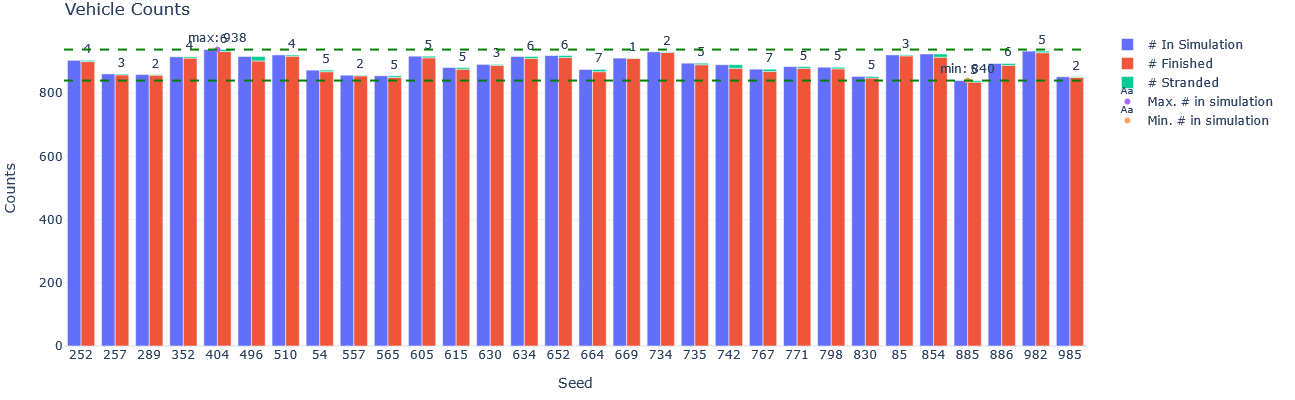

In [82]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['param_value'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['param_value'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['param_value'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=800, height=400
        
    )
)
fig.add_trace(go.Scatter(x=[count_stats['param_value'][max_counts_idxs['sim_count']]], 
                         y=[max_counts['sim_count']], 
                         mode="markers+text", 
                         text=['max: ' + str(trunc(max_counts['sim_count']))], 
                         textposition="top center", name='Max. # in simulation'))
fig.add_trace(go.Scatter(x=[count_stats['param_value'][min_counts_idxs['sim_count']]], 
                         y=[min_counts['sim_count']], mode="markers+text", 
                         text=['min: ' + str(trunc(min_counts['sim_count']))], 
                         textposition="top center", name='Min. # in simulation'))
fig.add_hline(y=max_counts['sim_count'], line_dash="dash", line_color="green")
fig.add_hline(y=min_counts['sim_count'], line_dash="dash", line_color="green")
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

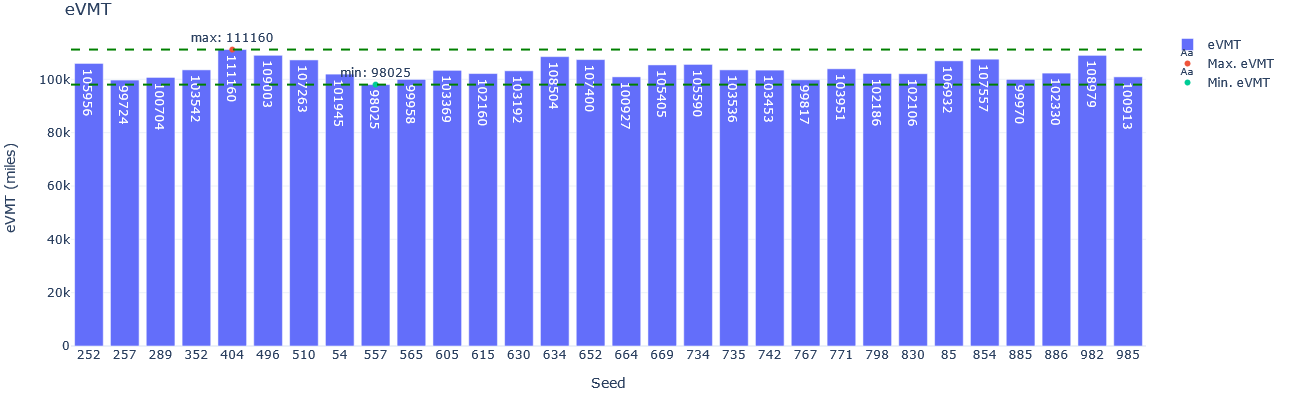

In [79]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['param_value'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Seed", uniformtext_minsize=8, uniformtext_mode='hide', width=600, height=400
        
    )
)
fig.add_trace(go.Scatter(x=[count_stats['param_value'][max_counts_idxs['evmt']]], 
                         y=[max_counts['evmt']], 
                         mode="markers+text", 
                         text=['max: ' + str(trunc(max_counts['evmt']))], 
                         textposition="top center", name='Max. eVMT'))
fig.add_trace(go.Scatter(x=[count_stats['param_value'][min_counts_idxs['evmt']]], 
                         y=[min_counts['evmt']], mode="markers+text", 
                         text=['min: ' + str(trunc(min_counts['evmt']))], 
                         textposition="top center", name='Min. eVMT'))
fig.add_hline(y=max_counts['evmt'], line_dash="dash", line_color="green")
fig.add_hline(y=min_counts['evmt'], line_dash="dash", line_color="green")
fig.update_xaxes(type='category')

fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

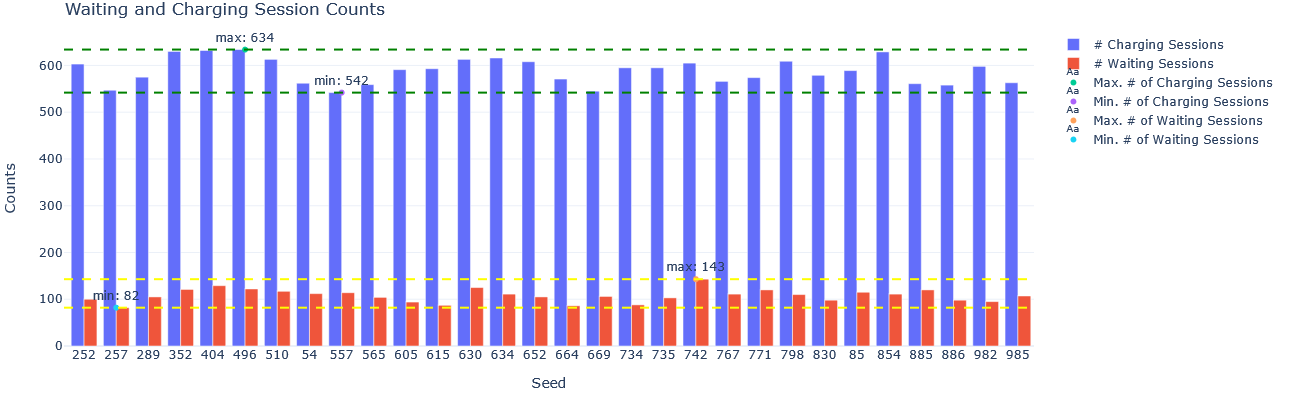

In [89]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['param_value'],
            y=count_stats['cs_count'],
            # offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['param_value'],
            y=count_stats['wait_count'],
            # offsetgroup=1,
            # base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=800, height=400
        
    )
)
fig.add_trace(go.Scatter(x=[count_stats['param_value'][max_counts_idxs['cs_count']]], 
                         y=[max_counts['cs_count']], 
                         mode="markers+text", 
                         text=['max: ' + str(trunc(max_counts['cs_count']))], 
                         textposition="top center", name='Max. # of Charging Sessions'))
fig.add_trace(go.Scatter(x=[count_stats['param_value'][min_counts_idxs['cs_count']]], 
                         y=[min_counts['cs_count']], mode="markers+text", 
                         text=['min: ' + str(trunc(min_counts['cs_count']))], 
                         textposition="top center", name='Min. # of Charging Sessions'))
fig.add_hline(y=max_counts['cs_count'], line_dash="dash", line_color="green")
fig.add_hline(y=min_counts['cs_count'], line_dash="dash", line_color="green")
fig.add_trace(go.Scatter(x=[count_stats['param_value'][max_counts_idxs['wait_count']]], 
                         y=[max_counts['wait_count']], 
                         mode="markers+text", 
                         text=['max: ' + str(trunc(max_counts['wait_count']))], 
                         textposition="top center", name='Max. # of Waiting Sessions'))
fig.add_trace(go.Scatter(x=[count_stats['param_value'][min_counts_idxs['wait_count']]], 
                         y=[min_counts['wait_count']], mode="markers+text", 
                         text=['min: ' + str(trunc(min_counts['wait_count']))], 
                         textposition="top center", name='Min. # of Waiting Sessions'))
fig.add_hline(y=max_counts['wait_count'], line_dash="dash", line_color="yellow")
fig.add_hline(y=min_counts['wait_count'], line_dash="dash", line_color="yellow")
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

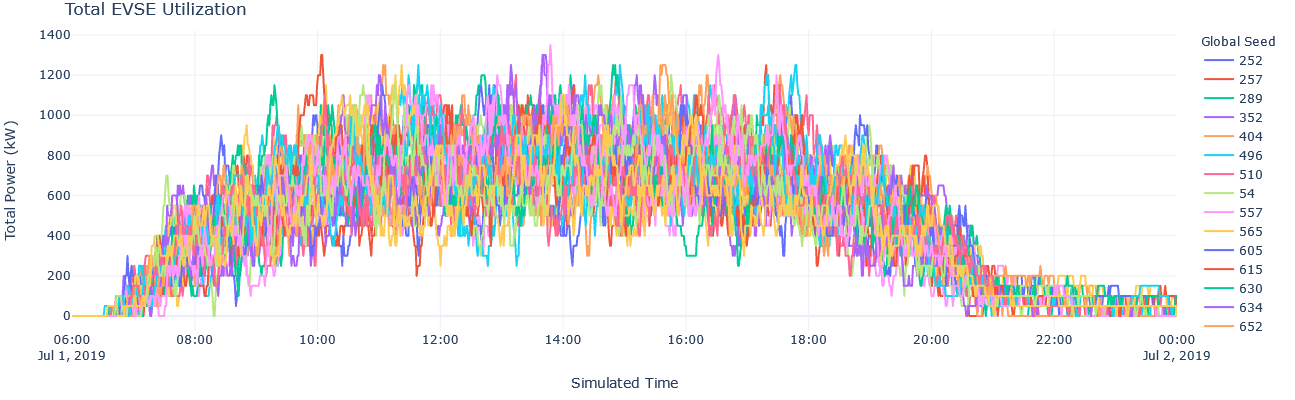

In [26]:
fig = px.line(evse_util, x="datetime", y="total_power", color='global_seed', labels={"global_seed": 'Global Seed'}, range_x=['2019-07-01 06:00','2019-07-02'])
fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white')
fig.show()

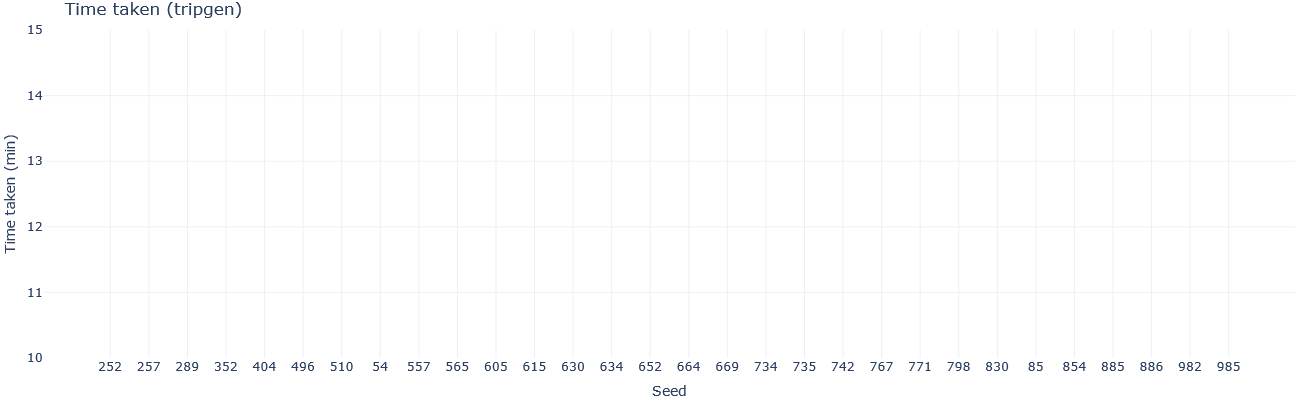

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='lines+markers', 
                         text=comp_stats['ev_count'],
                         textposition="top right"))
fig.update_xaxes(type='category', automargin=True)
fig.update_yaxes(range=(10, 15))
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=0, t=30, b=20),
                 template='plotly_white')
fig.show()

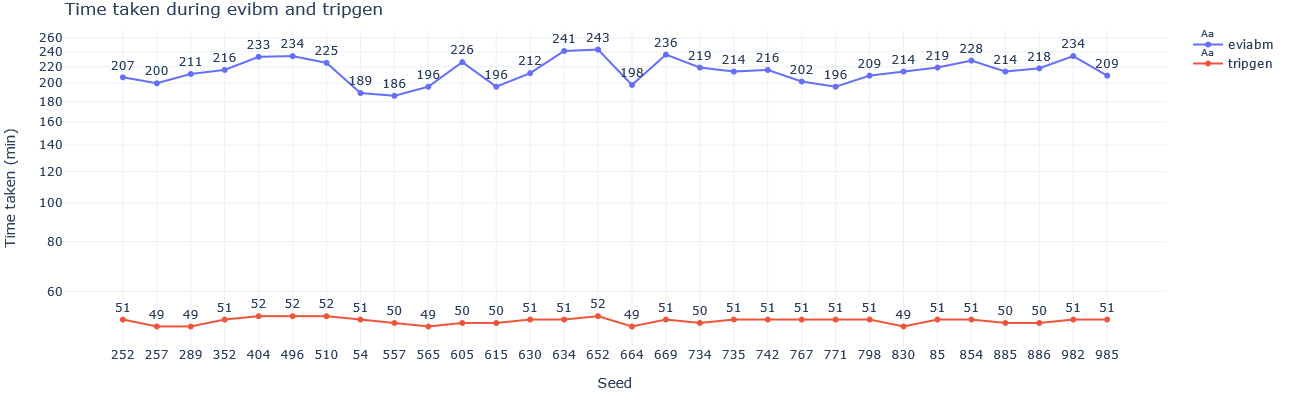

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='eviabm', text=comp_stats['time_taken_eviabm'],
                    textposition="top center"))
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='tripgen', text=comp_stats['time_taken_tripgen'],
                         textposition="top center"))
fig.update_xaxes(type='category')
fig.update_yaxes( type="log")
fig.update_layout(title="Time taken during evibm and tripgen",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=600, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()

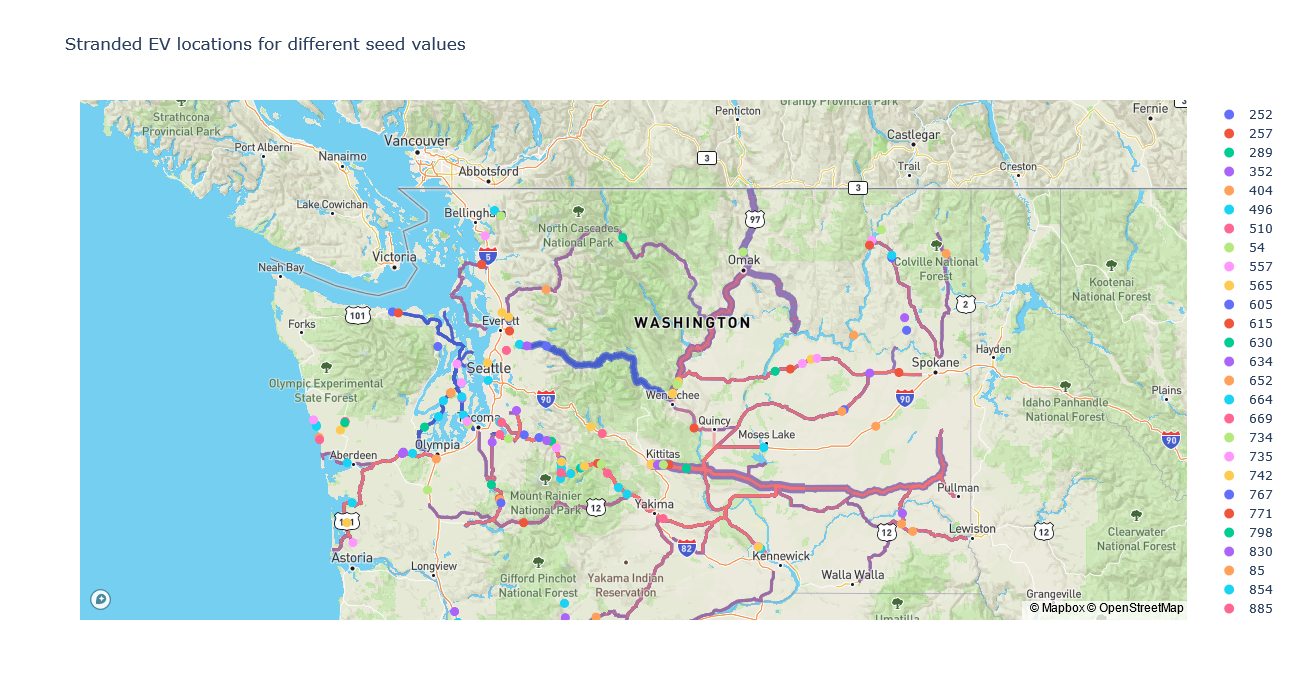

In [29]:
fig = go.Figure()
token = os.getenv("MAPBOX_ACCESS_TOKEN")
for seed in evs_str_loc['global_seed'].unique():
    fig.add_trace(go.Scattermapbox(
            lat=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lat'],
            lon=evs_str_loc[evs_str_loc['global_seed'] == seed]['stranded_lng'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10
            ), 
            name = seed
        ))

fig.update_layout(
        title_text = 'Stranded EV locations for different seed values',
        showlegend = True,
        mapbox_style="mapbox://styles/chintanp/ckhmnh3oa01r419pkc9qgn0sq", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700
    )

fig.show()

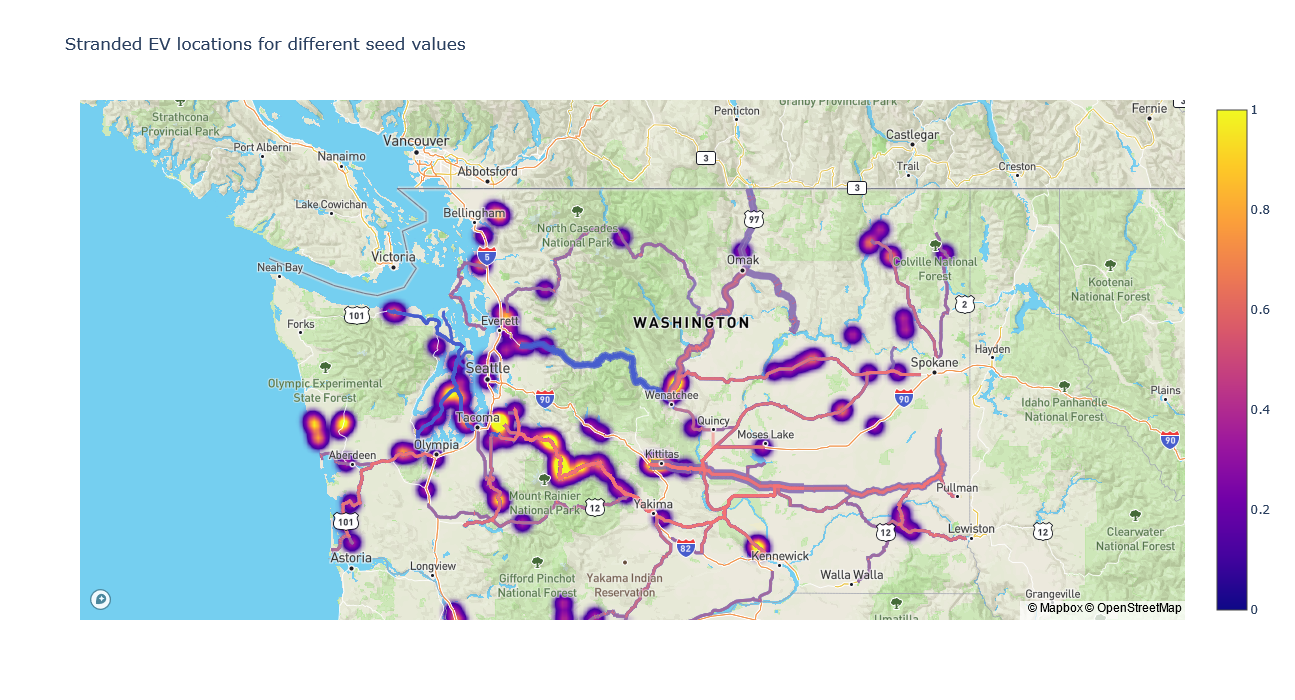

In [41]:
fig = go.Figure()
token = os.getenv("MAPBOX_ACCESS_TOKEN")
fig.add_trace(go.Densitymapbox(
        lat=evs_str_loc['stranded_lat'],
        lon=evs_str_loc['stranded_lng'],
        radius=15
    ))

fig.update_layout(
        title_text = 'Stranded EV locations for different seed values',
        showlegend = True,
        mapbox_style="mapbox://styles/chintanp/ckhmnh3oa01r419pkc9qgn0sq", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700
    )

fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [30]:
#!jupyter labextension list

In [31]:
#!jupyter labextension uninstall jupyterlab-plotly

In [32]:
#!jupyter labextension uninstall plotlywidget

In [33]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [34]:
#!pip show plotly

In [35]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [36]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [37]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [38]:
#!pip install "nbconvert<6"